In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout
import math
# np.random.seed(0)

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# shuffle = [x for x in range(len(data.values)) if x%2 == 0]
# comp = [x for x in range(len(data.values)) if x%2 ==1]
# shuffle.extend(comp)
shuffle = [0,1,2,3,4,5,6,7,8,30,28,26,24,22,20,9,10,12,14,16,18,29,27,25,23,21,19,17,15,13,11]

nsize = len(syscov)
# print(data.head(31))
# data.head(31) 
# plt.savefig("DistbinnedJLA.png")
np.shape(syscov)

errors = np.diag(syscov).reshape(nsize,1)
errors = np.where(errors!= 0, np.log(errors), 0)

z = data.values[:,0][shuffle]
dl = data.values[:,1][shuffle]

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# index = np.argsort(z)
zz = np.log10(z)

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))


scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))
# dll = dl.reshape(nsize, 1)


# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(zz, indx)
y = dll
y_train, y_test = np.split(y, indx)
# y


In [5]:
def model2_dropout(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.001)(efirst)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.001)(x)
    x = Dense(150, activation='relu')(x)
    x = MCDropout(0.001)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               15150     
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 150)               0     

In [6]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=4,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/2000
6/6 [==============================] - 0s 49ms/step - loss: 1.0309 - val_loss: 0.2879
Epoch 2/2000
6/6 [==============================] - 0s 4ms/step - loss: 1.0280 - val_loss: 0.3402
Epoch 3/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6511 - val_loss: 0.4229
Epoch 4/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.7137 - val_loss: 0.4148
Epoch 5/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.8377 - val_loss: 0.2411
Epoch 6/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.5297 - val_loss: 0.1982
Epoch 7/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.5420 - val_loss: 0.1320
Epoch 8/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.2282 - val_loss: 0.0396
Epoch 9/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.1042 - val_loss: 0.0066
Epoch 10/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.0103
Epoch 11/2000
6/6 

6/6 [==============================] - 0s 4ms/step - loss: 9.2107e-04 - val_loss: 9.8465e-04
Epoch 82/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 83/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 84/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 5.2653e-04
Epoch 85/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 86/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 87/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 88/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 4.4846e-04
Epoch 89/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 90/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 7.4426e-04
Epoc

6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.4449e-04
Epoch 162/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 163/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 3.2642e-04
Epoch 164/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 165/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 6.4743e-04
Epoch 166/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.1921e-04 - val_loss: 0.0037
Epoch 167/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 9.0376e-04
Epoch 168/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 169/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 8.1061e-04
Epoch 170/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.2861e-04 - val_

6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 242/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 7.4459e-04
Epoch 243/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 244/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 245/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 8.5758e-04
Epoch 246/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.7235e-04 - val_loss: 0.0014
Epoch 247/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 5.2120e-04
Epoch 248/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 3.3129e-04
Epoch 249/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.4556e-04
Epoch 250/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss

6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 8.7912e-04
Epoch 321/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 2.5357e-04
Epoch 322/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 323/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 324/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 325/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 326/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 327/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 5.9445e-04
Epoch 328/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 329/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0011
Epo

6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 5.1102e-04
Epoch 401/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.5391e-04
Epoch 402/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.1959e-04
Epoch 403/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 404/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 405/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.7123e-04
Epoch 406/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.8404e-04 - val_loss: 9.6832e-04
Epoch 407/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.2042e-04
Epoch 408/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 7.1078e-04
Epoch 409/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0044 - 

Epoch 480/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 8.7930e-04
Epoch 481/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 5.4565e-04
Epoch 482/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.4271e-04 - val_loss: 7.1829e-04
Epoch 483/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.7151e-04 - val_loss: 4.3156e-04
Epoch 484/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 6.0379e-04
Epoch 485/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 486/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 5.5892e-04
Epoch 487/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 5.6969e-04
Epoch 488/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 489/2000
6/6 [==============================] - 0s 4ms/ste

6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 7.7657e-04
Epoch 560/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.8087e-04
Epoch 561/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.6879e-04
Epoch 562/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 6.6953e-04
Epoch 563/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.5665e-04 - val_loss: 8.0169e-04
Epoch 564/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.3631e-04
Epoch 565/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.0656e-04 - val_loss: 7.0450e-04
Epoch 566/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 7.3217e-04
Epoch 567/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 9.6433e-04
Epoch 568/2000
6/6 [==============================] - 0s 4ms/step - los

Epoch 638/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.1489e-04
Epoch 639/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 640/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 641/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.0363e-04 - val_loss: 6.4686e-04
Epoch 642/2000
6/6 [==============================] - 0s 4ms/step - loss: 4.8305e-04 - val_loss: 6.2485e-04
Epoch 643/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 644/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 4.6122e-04
Epoch 645/2000
6/6 [==============================] - 0s 4ms/step - loss: 6.3244e-04 - val_loss: 9.3404e-04
Epoch 646/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.9655e-04 - val_loss: 7.0980e-04
Epoch 647/2000
6/6 [==============================] - 0s 5ms

6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 717/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 718/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 719/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 720/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 721/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 722/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 723/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 9.5941e-04
Epoch 724/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 725/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 8.5995e-04
Epoch 7

6/6 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 796/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 5.7800e-04
Epoch 797/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.5527e-04
Epoch 798/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.8071e-04
Epoch 799/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 9.2109e-04
Epoch 800/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 5.2576e-04
Epoch 801/2000
6/6 [==============================] - 0s 8ms/step - loss: 8.4944e-04 - val_loss: 0.0013
Epoch 802/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 803/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.3133e-04
Epoch 804/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_

6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.0626e-04
Epoch 875/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.4279e-04 - val_loss: 7.3425e-04
Epoch 876/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.3698e-04 - val_loss: 6.5354e-04
Epoch 877/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 5.5209e-04
Epoch 878/2000
6/6 [==============================] - 0s 4ms/step - loss: 6.8565e-04 - val_loss: 9.6540e-04
Epoch 879/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.2475e-04 - val_loss: 9.6486e-04
Epoch 880/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 7.4095e-04
Epoch 881/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.9254e-04 - val_loss: 8.0261e-04
Epoch 882/2000
6/6 [==============================] - 0s 4ms/step - loss: 4.4166e-04 - val_loss: 0.0010
Epoch 883/2000
6/6 [==============================] - 0s 4m

6/6 [==============================] - 0s 4ms/step - loss: 9.3621e-04 - val_loss: 5.0723e-04
Epoch 954/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 955/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.5950e-04
Epoch 956/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 6.3490e-04
Epoch 957/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 8.7581e-04
Epoch 958/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.8217e-04 - val_loss: 5.6094e-04
Epoch 959/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.5835e-04
Epoch 960/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.8732e-04 - val_loss: 5.8106e-04
Epoch 961/2000
6/6 [==============================] - 0s 4ms/step - loss: 6.3705e-04 - val_loss: 6.9437e-04
Epoch 962/2000
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 4.7203e-04 - val_loss: 0.0013
Epoch 1033/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.8562e-04 - val_loss: 0.0015
Epoch 1034/2000
6/6 [==============================] - 0s 4ms/step - loss: 6.6315e-04 - val_loss: 9.6390e-04
Epoch 1035/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 1036/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 6.5772e-04
Epoch 1037/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 1038/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 1039/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1040/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1041/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val

6/6 [==============================] - 0s 4ms/step - loss: 7.7704e-04 - val_loss: 8.0258e-04
Epoch 1112/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 7.1517e-04
Epoch 1113/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.0771e-04 - val_loss: 0.0015
Epoch 1114/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 9.7546e-04
Epoch 1115/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 1116/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 7.0996e-04
Epoch 1117/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 1118/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 5.3650e-04
Epoch 1119/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 1120/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.00

6/6 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 1190/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 1191/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 9.7922e-04
Epoch 1192/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.7982e-04 - val_loss: 0.0015
Epoch 1193/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 8.8793e-04
Epoch 1194/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 5.3854e-04
Epoch 1195/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.8483e-04
Epoch 1196/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1197/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.9552e-04 - val_loss: 0.0012
Epoch 1198/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0027 -

6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 1268/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 6.6197e-04
Epoch 1269/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.4435e-04 - val_loss: 0.0013
Epoch 1270/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.8732e-04
Epoch 1271/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 6.4891e-04
Epoch 1272/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.9590e-04
Epoch 1273/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.4291e-04 - val_loss: 9.6872e-04
Epoch 1274/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.2897e-04 - val_loss: 0.0012
Epoch 1275/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.2556e-04 - val_loss: 0.0011
Epoch 1276/2000
6/6 [==============================] - 0s 4ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 9.7389e-04
Epoch 1346/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 8.2156e-04
Epoch 1347/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 1348/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1349/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.4566e-04 - val_loss: 0.0014
Epoch 1350/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 1351/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 1352/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 1353/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 1354/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.5127e-04
Epoch 1424/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 1425/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 9.0509e-04
Epoch 1426/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 1427/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 1428/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 1429/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1430/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 1431/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 8.3951e-04
Epoch 1432/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9

Epoch 1502/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.8375e-04 - val_loss: 8.0921e-04
Epoch 1503/2000
6/6 [==============================] - 0s 5ms/step - loss: 9.5732e-04 - val_loss: 0.0012
Epoch 1504/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 7.5731e-04
Epoch 1505/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.0230e-04 - val_loss: 0.0013
Epoch 1506/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 5.2721e-04
Epoch 1507/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1508/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 8.6300e-04
Epoch 1509/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 1510/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 7.9899e-04
Epoch 1511/2000
6/6 [==============================] - 0s 4

Epoch 1581/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.2978e-04 - val_loss: 0.0010
Epoch 1582/2000
6/6 [==============================] - 0s 4ms/step - loss: 4.2526e-04 - val_loss: 0.0014
Epoch 1583/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 5.5990e-04
Epoch 1584/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1585/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 7.4071e-04
Epoch 1586/2000
6/6 [==============================] - 0s 4ms/step - loss: 2.9264e-04 - val_loss: 0.0010
Epoch 1587/2000
6/6 [==============================] - 0s 4ms/step - loss: 4.4944e-04 - val_loss: 0.0015
Epoch 1588/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.8265e-04 - val_loss: 9.9748e-04
Epoch 1589/2000
6/6 [==============================] - 0s 4ms/step - loss: 3.4461e-04 - val_loss: 9.8559e-04
Epoch 1590/2000
6/6 [==============================

6/6 [==============================] - 0s 4ms/step - loss: 8.9535e-04 - val_loss: 0.0012
Epoch 1660/2000
6/6 [==============================] - 0s 5ms/step - loss: 8.1743e-04 - val_loss: 0.0010
Epoch 1661/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.9120e-04 - val_loss: 0.0011
Epoch 1662/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 1663/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1664/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 8.9290e-04
Epoch 1665/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.4721e-04 - val_loss: 6.9566e-04
Epoch 1666/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.4684e-04 - val_loss: 5.0894e-04
Epoch 1667/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 5.5249e-04
Epoch 1668/2000
6/6 [==============================] - 0s 4ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 6.8813e-04 - val_loss: 0.0012
Epoch 1739/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 1740/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 7.9465e-04
Epoch 1741/2000
6/6 [==============================] - 0s 5ms/step - loss: 7.3578e-04 - val_loss: 7.9886e-04
Epoch 1742/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 1743/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 1744/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.6749e-04
Epoch 1745/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.7019e-04 - val_loss: 7.0131e-04
Epoch 1746/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.0568e-04
Epoch 1747/2000
6/6 [==============================] - 0s 4ms/step - loss: 

6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 7.6273e-04
Epoch 1817/2000
6/6 [==============================] - 0s 4ms/step - loss: 8.5784e-04 - val_loss: 0.0012
Epoch 1818/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 8.0734e-04
Epoch 1819/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 5.2904e-04
Epoch 1820/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.8044e-04
Epoch 1821/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 5.4305e-04
Epoch 1822/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 9.7592e-04
Epoch 1823/2000
6/6 [==============================] - 0s 4ms/step - loss: 5.4496e-04 - val_loss: 4.2420e-04
Epoch 1824/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.4824e-04 - val_loss: 0.0011
Epoch 1825/2000
6/6 [==============================] - 0s 6ms/step 

6/6 [==============================] - 0s 4ms/step - loss: 8.5861e-04 - val_loss: 0.0011
Epoch 1895/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.8988e-04 - val_loss: 0.0013
Epoch 1896/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.9406e-04
Epoch 1897/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.5433e-04
Epoch 1898/2000
6/6 [==============================] - 0s 4ms/step - loss: 6.3372e-04 - val_loss: 5.5303e-04
Epoch 1899/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 1900/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1901/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 1902/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 1903/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.7798e-

6/6 [==============================] - 0s 4ms/step - loss: 8.5636e-04 - val_loss: 6.9423e-04
Epoch 1973/2000
6/6 [==============================] - 0s 4ms/step - loss: 3.4547e-04 - val_loss: 9.5471e-04
Epoch 1974/2000
6/6 [==============================] - 0s 4ms/step - loss: 7.8911e-04 - val_loss: 9.0149e-04
Epoch 1975/2000
6/6 [==============================] - 0s 4ms/step - loss: 4.5073e-04 - val_loss: 8.2177e-04
Epoch 1976/2000
6/6 [==============================] - 0s 4ms/step - loss: 9.0550e-04 - val_loss: 7.7929e-04
Epoch 1977/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 6.0444e-04
Epoch 1978/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.5019e-04
Epoch 1979/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.4542e-04
Epoch 1980/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.3075e-04
Epoch 1981/2000
6/6 [==============================

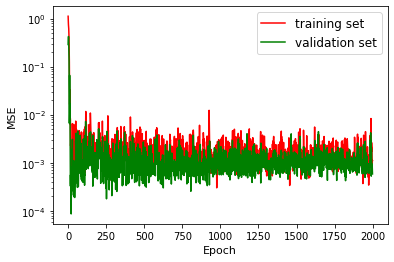

In [7]:
# plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.xticks([])
# plt.yticks([])
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [8]:
# file3 = 'fake_binned_JLA2TEST3new.dat'
# data3 = np.loadtxt(file3, skiprows=3)

# z_test = data3[:,0]
z_test = zz
# z_test = np.log10(np.linspace(0.01,1.3,1000))
# x_test

In [9]:
test_batch_size = len(z_test)
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(z_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))


# sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)




In [10]:
# predictions_err

In [11]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [12]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

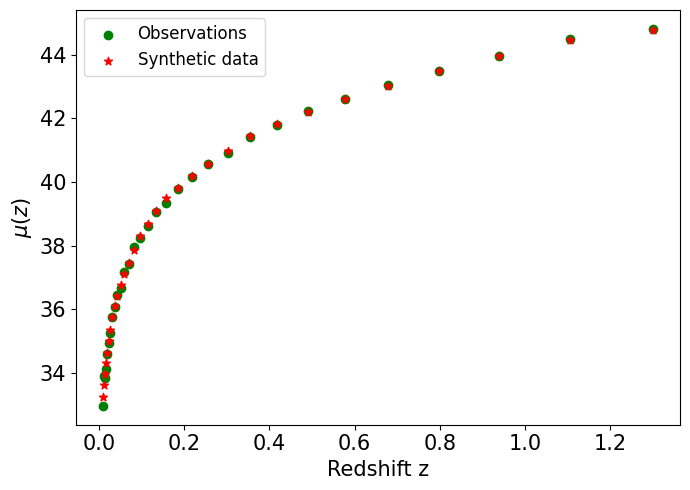

In [13]:
plt.figure(figsize=(7, 5), dpi=100)

# Plotting
dlfake = scalerdl.inverse_transform(prediction_mc_dropout.reshape(-1,1))[:,0]
# dlfake = prediction_mc_dropout[:,0]
# plt.figure(figsize=(10, 7), dpi=100)

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(10**z_test, dlfake, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
# plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
# plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')

plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [14]:
index = np.argsort(z_test)
fake_data2 = np.stack((z[index], dlfake[index]), axis=1)


# np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [15]:
tf.keras.models.save_model(neural_model2, '../models/FFNN_JLA_DO2.h5' )